# pycalphad triangluar

Make ternary isotherms with pycalphad. 

The following database can be found at https://doi.org/10.1016/j.jnoncrysol.2016.09.031. It is not linked in this repo because the file is behind a paywall. Nevertheless, changing the database and component names should give you the same plot in any case. 

In [1]:
database_file = '/home/bocklund/BMG/databases/Al-Cu-Zr_Zhou.TDB'

Imports and setup of the database

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import collections as mc
import numpy as np
from pycalphad import Database, equilibrium, Model, variables as v
from pycalphad.plot.utils import phase_legend

# a little bit of magic to get the triangular projection
from importlib import import_module
trangular = import_module('triangular', '.')

dbf = Database(database_file)

/home/bocklund/anaconda3/envs/pycalphad/lib/python3.6/site-packages/xarray/core/formatting.py:16: FutureWarning: The pandas.tslib module is deprecated and will be removed in a future version.
  from pandas.tslib import OutOfBoundsDatetime


In [3]:
phases = list(dbf.phases.keys())
comps = ['AL', 'CU', 'ZR', 'VA']
conditions = {v.X('AL'): (0,1,0.008), v.X('ZR'): (0,1,0.008), v.P: 101325, v.T: 1373}

eq_res = equilibrium(dbf, comps, phases, conditions, model=Model, calc_opts={'pdens': 2000}) 

Failed to converge: OrderedDict([('P', array(101325.0)), ('T', array(1373.0)), ('X_AL', array(1e-09)), ('X_ZR', array(0.168))])
Failed to converge: OrderedDict([('P', array(101325.0)), ('T', array(1373.0)), ('X_AL', array(0.84)), ('X_ZR', array(0.056))])
Failed to converge: OrderedDict([('P', array(101325.0)), ('T', array(1373.0)), ('X_AL', array(0.8320000000000001)), ('X_ZR', array(0.056))])
Failed to converge: OrderedDict([('P', array(101325.0)), ('T', array(1373.0)), ('X_AL', array(0.112)), ('X_ZR', array(0.8160000000000001))])
Failed to converge: OrderedDict([('P', array(101325.0)), ('T', array(1373.0)), ('X_AL', array(1e-09)), ('X_ZR', array(0.264))])
Failed to converge: OrderedDict([('P', array(101325.0)), ('T', array(1373.0)), ('X_AL', array(0.976)), ('X_ZR', array(0.008))])
Failed to converge: OrderedDict([('P', array(101325.0)), ('T', array(1373.0)), ('X_AL', array(0.20800000000000002)), ('X_ZR', array(0.008))])
Failed to converge: OrderedDict([('P', array(101325.0)), ('T', ar

Select phase regions from calculated result. Note that Gibbs phase rule is `d=c-p` because temperature and pressure are fixed.

Thus points can have up to three phases in equilibrium, lines two phases

In [4]:
three_phase_idx = np.nonzero(np.sum(eq_res.Phase.values != '', axis=-1, dtype=np.int) == 3)
two_phase_idx =  np.nonzero(np.sum(eq_res.Phase.values != '', axis=-1, dtype=np.int) == 2)
single_phase_idx = np.nonzero(np.sum(eq_res.Phase.values != '', axis=-1, dtype=np.int) == 1)
found_single_phase = eq_res.Phase.values[single_phase_idx][..., :1]
single_phase_comp_x = eq_res.X.sel(component='ZR').values[single_phase_idx][..., :1]
single_phase_comp_y = eq_res.X.sel(component='AL').values[single_phase_idx][..., :1]
found_two_phase = eq_res.Phase.values[two_phase_idx][..., :2]
found_three_phase = eq_res.Phase.values[three_phase_idx][..., :3]
two_phase_comp_x = eq_res.X.sel(component='ZR').values[two_phase_idx][..., :2]
two_phase_comp_y = eq_res.X.sel(component='AL').values[two_phase_idx][..., :2]
three_phase_comp_x = eq_res.X.sel(component='ZR').values[three_phase_idx][..., :3]
three_phase_comp_y = eq_res.X.sel(component='AL').values[three_phase_idx][..., :3]


In [5]:
# collect tilines into a line collection
# note: if you want to use the LineCollection approach, you have to del the variables before trying to add the collection the axes again. 
# For some reason you can only have LineCollections associated with one Axes object and it seems that the ax instance of that object is not getting
# garbage collected when you rerun the next cell
tielines = np.array([np.concatenate((two_phase_comp_x[..., 0][..., np.newaxis], two_phase_comp_y[..., 0][..., np.newaxis]), axis=-1),
                     np.concatenate((two_phase_comp_x[..., 1][..., np.newaxis], two_phase_comp_y[..., 1][..., np.newaxis]), axis=-1)])
tielines = np.rollaxis(tielines,1)
lc = mc.LineCollection(tielines, zorder=1, colors=[0,1,0,1], linewidths=[0.5, 0.5])


# three phase tielines
three_phase_tielines = np.array([np.concatenate((three_phase_comp_x[..., 0][..., np.newaxis], three_phase_comp_y[..., 0][..., np.newaxis]), axis=-1),
                                 np.concatenate((three_phase_comp_x[..., 1][..., np.newaxis], three_phase_comp_y[..., 1][..., np.newaxis]), axis=-1),
                                 np.concatenate((three_phase_comp_x[..., 2][..., np.newaxis], three_phase_comp_y[..., 2][..., np.newaxis]), axis=-1)])
three_phase_tielines = np.rollaxis(three_phase_tielines,1)
three_lc = mc.LineCollection(three_phase_tielines, zorder=1, colors=[1,0,0,1], linewidths=[0.5, 0.5])

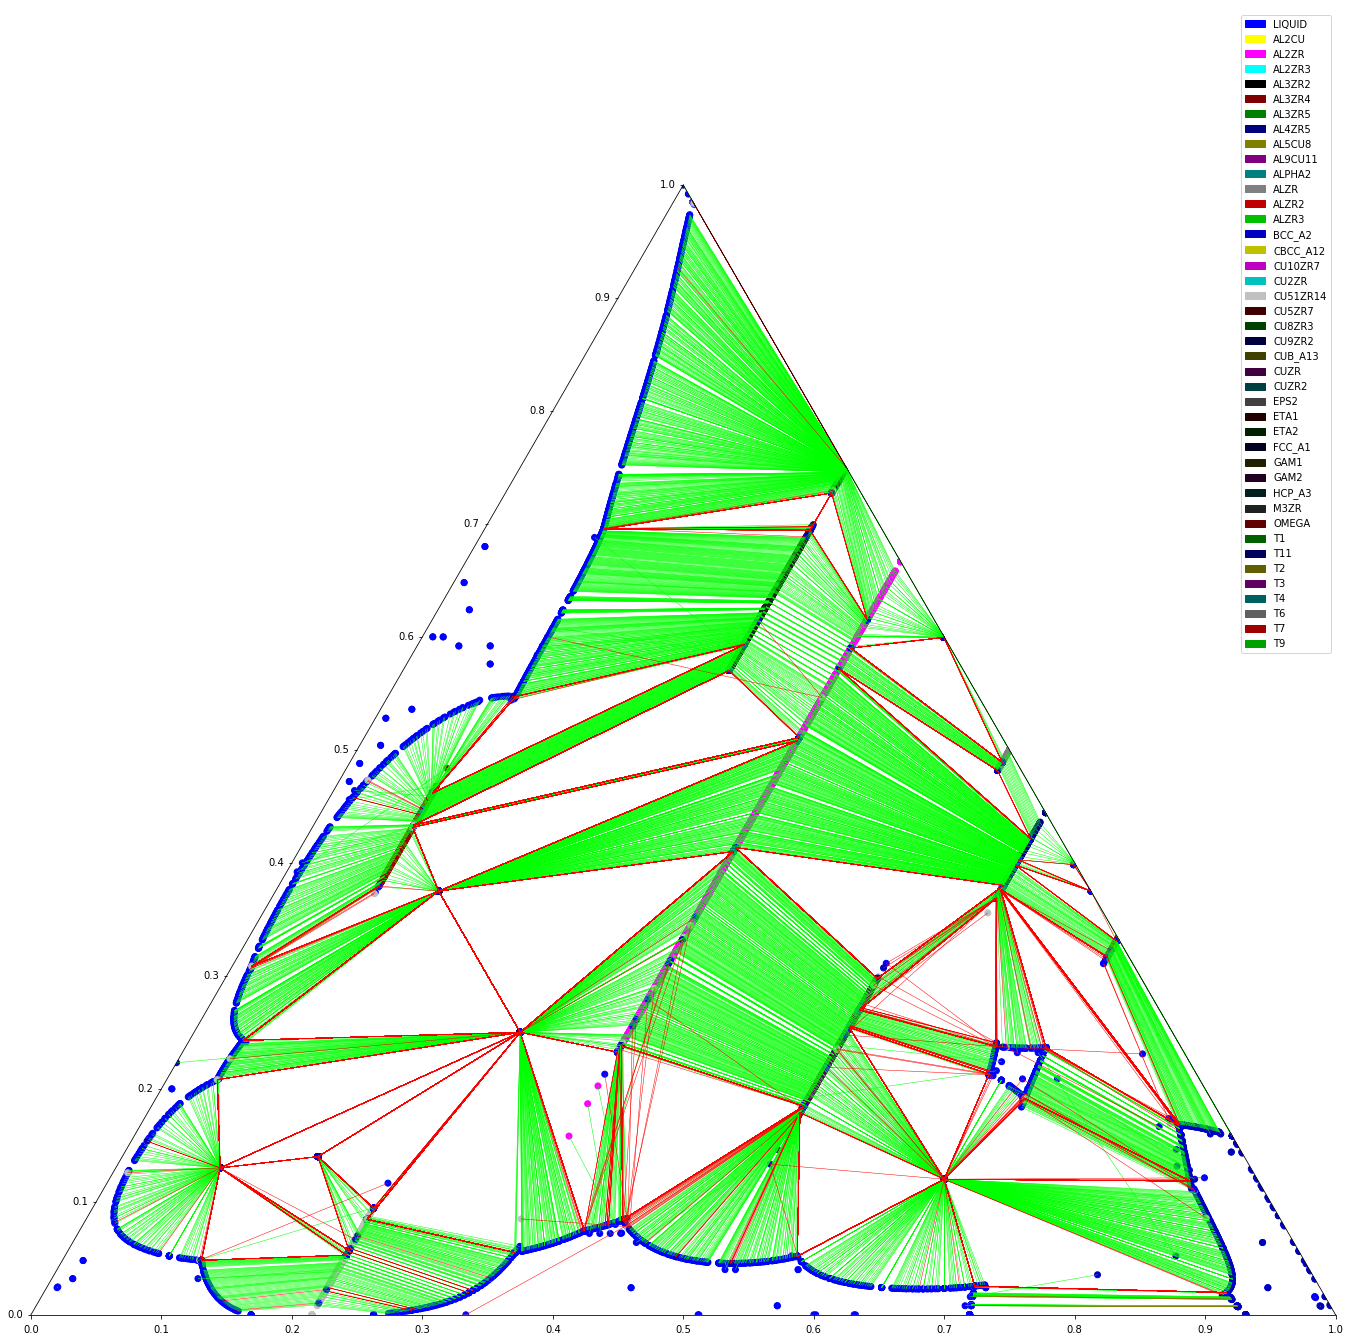

In [6]:
fig = plt.figure(figsize=(24,24))
ax = fig.gca(projection='triangular')
stable_phases = map(str, sorted(set(np.array(eq_res.Phase.values.ravel(), dtype='U'))-{''},key=str))
legend_handles, colorlist = phase_legend(phases)
#single_phase_plotcolors = np.array(list(map(lambda x: [colorlist[x[0]]], found_single_phase)), dtype='U') # from pycalphad
two_phase_plotcolors = np.array(list(map(lambda x: [colorlist[x[0]], colorlist[x[1]]], found_two_phase)), dtype='U') # from pycalphad
three_phase_plotcolors = np.array(list(map(lambda x: [colorlist[x[0]], colorlist[x[1]], colorlist[x[2]]], found_three_phase)), dtype='U') # from pycalphad
#ax.scatter(single_phase_comp_x[..., 0], single_phase_comp_y[..., 0], c=single_phase_plotcolors[0])
ax.scatter(two_phase_comp_x[..., 0], two_phase_comp_y[..., 0], c=two_phase_plotcolors[:,0])
ax.scatter(two_phase_comp_x[..., 1], two_phase_comp_y[..., 1], c=two_phase_plotcolors[:,1])
ax.scatter(three_phase_comp_x[..., 0], three_phase_comp_y[..., 0], c=three_phase_plotcolors[0])
ax.scatter(three_phase_comp_x[..., 1], three_phase_comp_y[..., 1], c=three_phase_plotcolors[1])
ax.scatter(three_phase_comp_x[..., 2], three_phase_comp_y[..., 2], c=three_phase_plotcolors[2])
ax.add_collection(lc)
ax.add_collection(three_lc)
ax.legend(handles=legend_handles)